In [1]:
#\-- IMPORT MODULES, CLASSES AND METHODS --/#

import zipfile                          #############################
import os                               # || FILE SYSTEM / UTILS || #
import copy                             #############################
from prettytable import PrettyTable
import copy

# ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

import numpy as np                  ###################################
import pandas as pd                 # || EXPLORATIVE DATA ANALYSIS || #
import matplotlib.pyplot as plt     ###################################
import seaborn as sns
import matplotlib
# https://towardsdatascience.com/handling-missing-data-like-a-pro-part-3-model-based-multiple-imputation-methods-bdfe85f93087 NumPyro, impyute,

# ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

import sklearn
import re
import importlib
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from sklearn import naive_bayes                         #########################
from sklearn import neural_network                      #  |-----------------|  #
from sklearn import svm                                 # || MODEL SELECTION || #
from sklearn import tree                                #  |-----------------|  #
from sklearn import linear_model                        #########################

# from PrunedCV import PrunedCV

# ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.model_selection import StratifiedKFold     ##########################
from sklearn.model_selection import ParameterGrid       # || MODEL VALIDATION || #
                                                        ##########################

%matplotlib inline


from bs4 import BeautifulSoup
import requests
from selenium import webdriver
import re
from datetime import datetime, timedelta

In [2]:
#\-- SET ENVIRONMENT --/#
# Before starting we need to store the data properly. We define an ad-hoc folder where we will store everything.
main_PATH = os.getcwd()

# We check whether we already have the data.                        
if 'data' not in os.listdir():                                      
                                                                    
    # Unzip files.
    with zipfile.ZipFile(r'summer_project_dataset.zip') as zip_ref:

        os.mkdir(main_PATH + '/data')   # We create the 'data' directory,
        os.chdir(main_PATH + '/data')   # we change directory,
    
        data_PATH = os.getcwd()         # we get the data path
        zip_ref.extractall(data_PATH)   # and we unzip there.       #####################
                                                                    # || FILE SYSTEM || #    
    file_PATH = data_PATH + '/summer_project_dataset'               #####################

else:

    # We just build the paths.
    data_PATH = main_PATH + '/data'
    file_PATH = data_PATH + '/summer_project_dataset'

# Finally, we go back to our main path.
os.chdir(main_PATH)

# ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# We also set a seed for reproducibility purposes.      #####################
SEED = 42                                               # || RANDOM SEED || #
np.random.seed(SEED)                                    #####################

# ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# LaTeX style plots.
plt.rcParams['figure.figsize'] = (12, 8)
# plt.rcParams['text.usetex']    = True         ############################
# plt.rcParams['font.family']    = 'serif'      # || DEFAULT PARAMETERS || #
# plt.rcParams['font.size']      = '10'         ############################

pd.set_option('display.max_rows', 20)
# pd.set_option('display.max_rows', 10)

In [3]:
#\-- DATASET LOADING AND PREPROCESSING --/#
# Aome variables are stored as float, but they are actually int. Two reasons why:
#       -) nan values are considered as float --> first estimate them and then change the data type.
#       -) there are inconsistencies, especially in kw_max_min where some int values are float instead.
# for the moment just let's store everything as float, but further inspections are needed.

data_types = {
              'url' : str, 'timedelta' : int, 'shares' : int, 'data_channel' : str, 'weekday' : str, 
              
              'n_tokens_title'          : int, 'n_tokens_content'       : int, 'n_unique_tokens' : float, 'n_non_stop_words' : float,
              'n_non_stop_unique_tokens': float, 'average_token_length' : float,

              'num_hrefs' : int, 'num_self_hrefs' : int, 'num_imgs' : float, 'num_videos' : float,
              
              'kw_min_min' : float, 'kw_max_min' : float, 'kw_avg_min' : float, 'kw_min_max' : float, 'kw_max_max'   : float,
              'kw_avg_max' : float, 'kw_min_avg' : float, 'kw_max_avg' : float, 'kw_avg_avg' : float, 'num_keywords' : float,
              
              'self_reference_min_shares' : float, 'self_reference_max_shares' : float, 'self_reference_avg_sharess' : float,
              
              'LDA_00' : float, 'LDA_01' : float, 'LDA_02' : float, 'LDA_03' : float, 'LDA_04' : float,
              
              'global_subjectivity' : float, 'global_sentiment_polarity' : float, 'global_rate_positive_words' : float, 'global_rate_negative_words' : float,
              
              'rate_positive_words' : float, 'rate_negative_words' : float,
              
              'avg_positive_polarity' : float, 'min_positive_polarity' : float, 'max_positive_polarity' : float, 'avg_negative_polarity' : float,
              'min_negative_polarity' : float, 'max_negative_polarity' : float,

              'title_subjectivity' : float, 'title_sentiment_polarity' : float, 'abs_title_subjectivity' : float, 'abs_title_sentiment_polarity' : float,
              }                                                    
                                                                   
                                                                   
df = pd.read_csv(file_PATH + r'/development.csv',                 
                   usecols = lambda column: column != 'id', dtype = data_types)              
df


,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,data_channel,weekday
0,http://mashable.com/2014/09/08/safest-cabbies-...,121,12,1015,0.422018,1.0,0.545031,10,6,33.0,...,-0.160714,-0.500000,-0.071429,0.000000,0.000,0.500000,0.000,2900,bus,tuesday
1,http://mashable.com/2013/07/25/3d-printed-rifle/,532,9,503,0.569697,1.0,0.737542,9,0,NaN,...,-0.157500,-0.250000,-0.100000,0.000000,0.000,0.500000,0.000,1300,tech,thursday
2,http://mashable.com/2013/10/30/digital-dinosau...,435,9,232,0.646018,1.0,0.748428,12,3,4.0,...,-0.427500,-1.000000,-0.187500,0.000000,0.000,0.500000,0.000,17700,lifestyle,wednesday
3,http://mashable.com/2014/08/27/homer-simpson-i...,134,12,171,0.722892,1.0,0.867925,9,5,0.0,...,-0.216667,-0.250000,-0.166667,0.400000,-0.250,0.100000,0.250,1500,bus,wednesday
4,http://mashable.com/2013/01/10/creepy-robotic-...,728,11,286,0.652632,1.0,0.800000,5,2,NaN,...,-0.251786,-0.500000,-0.100000,0.200000,-0.100,0.300000,0.100,1400,tech,thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31710,http://mashable.com/2014/11/30/star-wars-guard...,37,11,440,0.564103,1.0,0.718978,10,2,NaN,...,-0.209167,-0.316667,-0.050000,0.000000,0.000,0.500000,0.000,1000,world,tuesday
31711,http://mashable.com/2014/11/14/uk-floods/,52,14,0,0.000000,0.0,0.000000,0,0,0.0,...,0.000000,0.000000,0.000000,0.666667,-0.700,0.166667,0.700,11000,lifestyle,monday
31712,http://mashable.com/2014/09/08/paypal-bitcoin-...,121,9,969,0.489583,1.0,0.710623,6,5,2.0,...,-0.400000,-1.000000,-0.050000,0.000000,0.000,0.500000,0.000,2400,tech,tuesday
31713,http://mashable.com/2013/08/23/mashable-androi...,503,11,1976,0.412308,1.0,0.621080,21,3,1.0,...,-0.323413,-1.000000,-0.050000,0.700000,-0.400,0.200000,0.400,6000,lifestyle,friday


# Discard outliers from shares

30929 from 31715
97.52% of observations retained.


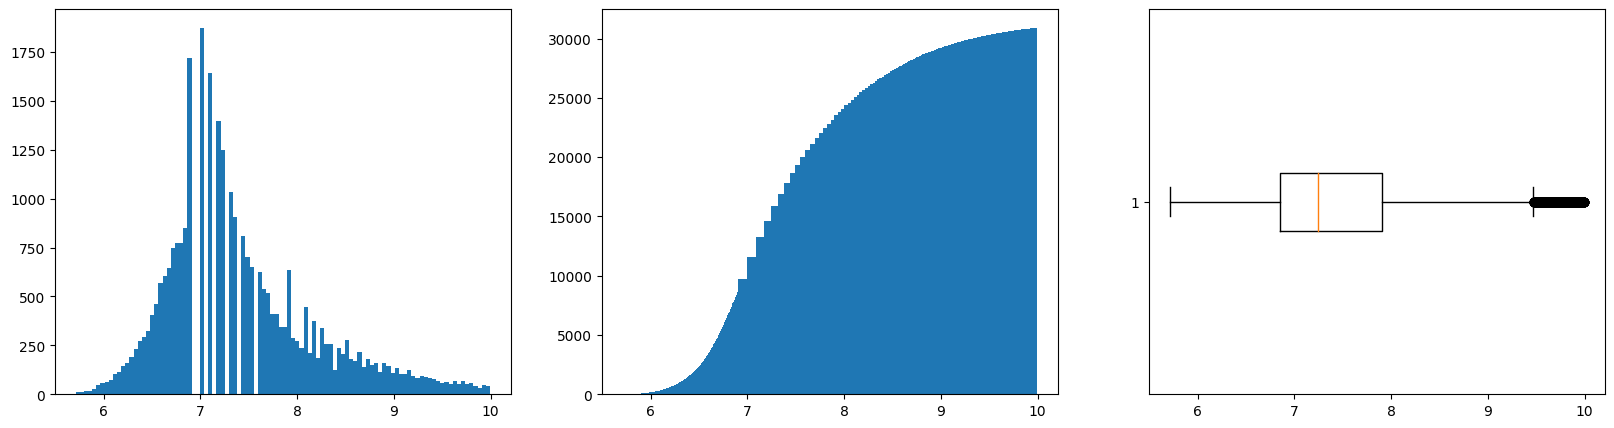

In [4]:
# We discard outliers using two subjective thresholds.
min = 300
max = 22000
df_filtered = df[(df['shares'] < max) & (df['shares'] > min)]

fig, ax = plt.subplots(1, 3, figsize = (20, 5))

ax[0].hist(np.log(df_filtered['shares']), bins = 100)
ax[1].hist(np.log(df_filtered['shares']), bins = 1000, cumulative = True)
ax[2].boxplot(np.log(df_filtered['shares']), vert = False)

print(f"{len(df_filtered['shares'])} from {len(df['shares'])}\n{len(df_filtered['shares']) / len(df['shares'])*100:.2f}% of observations retained.")


We can safely remove the most extreme observations by reducing just by a small percentage the total amount of data. We can do this because we have applied the logarithm, thus stabilizing the behaviour of the observations.

# Keywords

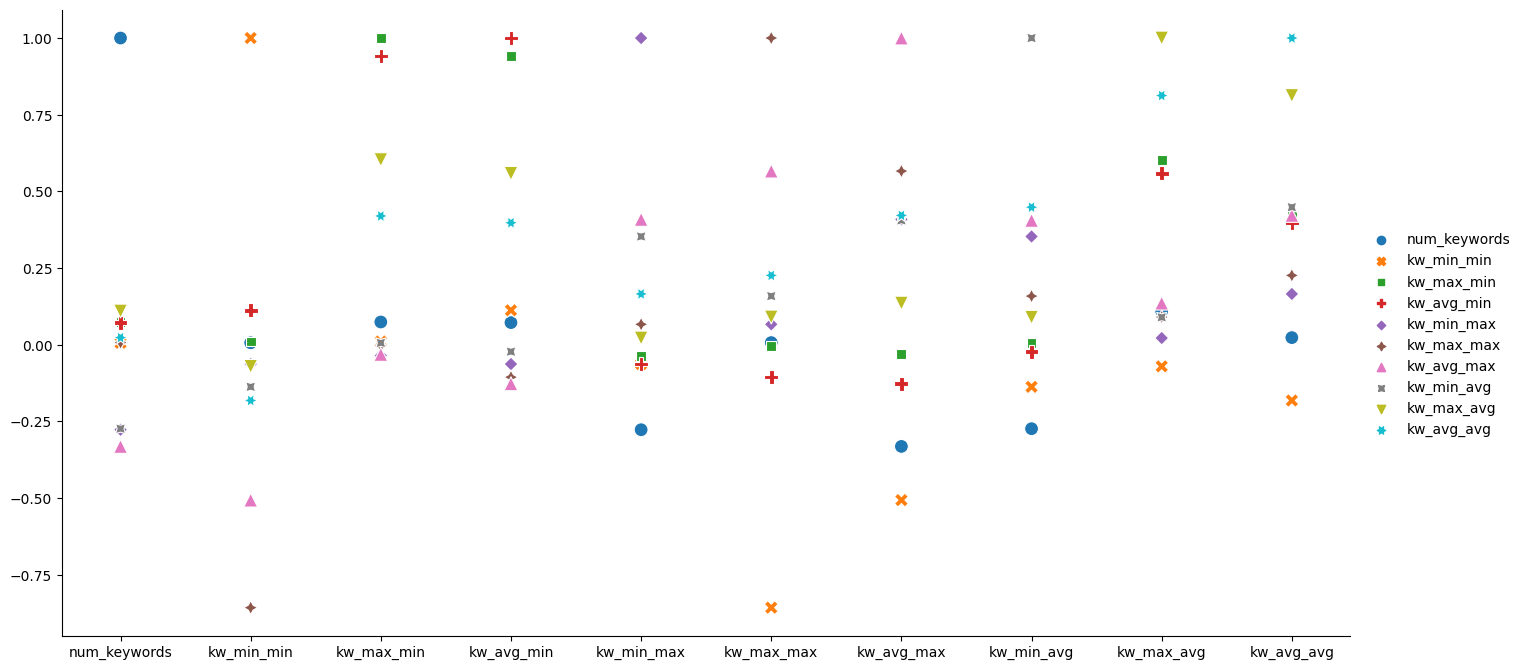

In [5]:
# Compute the linear correlation between kw.
corr_kw = df_filtered.loc[:, 'num_keywords':'kw_avg_avg'].corr()

sns.relplot(corr_kw, height = 7, aspect = 2, s = 100)


* kw_max_min strongly positively correlated to kw_avg_min > 0.90
* kw_max_avg strongly positively correlated to kw_avg_avg > 0.80
* kw_min_min strongly negatively correlated to kw_max_max < -0.80

* kw_max_min quite positively correlated to kw_kw_max_avg > 0.60
* kw_avg_min quite positively correlated to kw_kw_max_avg > 0.60
* kw_max_max quite positively correlated to kw_kw_avg_max > 0.60

We can safely discard some features. We choose to <br>

**KEEP**
* kw_avg_min 
* kw_avg_avg
* kw_max_max

**DISCARD**
* kw_max_min
* kw_max_avg
* kw_min_min

**TRANSFORM**
* kw_avg_max

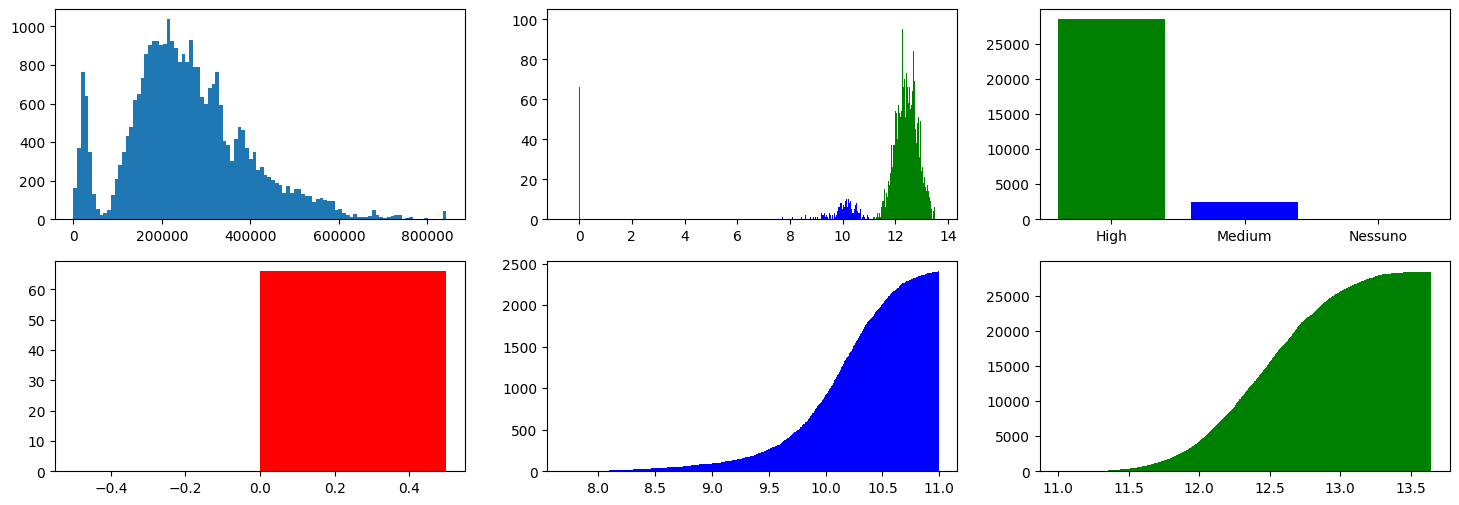

In [6]:
# We also discretize kw_avg_max. It looks like a bimodal distribution, we apply the log to stabilize more and preserve the 'None' information.
kw_filtered = copy.deepcopy(df_filtered)

conditions = [
    (np.log(kw_filtered['kw_avg_max'] + 1) < 2),
    ((np.log(kw_filtered['kw_avg_max'] + 1) < 11) & (np.log(kw_filtered['kw_avg_max'] + 1) > 0)),
    (np.log(kw_filtered['kw_avg_max'] + 1) > 11)
]

labels = ['Nessuno', 'Medium', 'High']

kw_filtered['discretized_kw_avg_max'] = np.where(conditions[0], labels[0],
                                                 np.where(conditions[1], labels[1],
                                                          np.where(conditions[2], labels[2], None)))



fig, ax = plt.subplots(2, 3, figsize = (18, 6))

ax[0, 0].hist(df_filtered['kw_avg_max'], bins = 100, cumulative = False)

ax[0, 1].hist(np.log(kw_filtered[conditions[0]]['kw_avg_max'] + 1), bins = 40, cumulative = False, color='red', label='Nessuno')
ax[0, 1].hist(np.log(kw_filtered[conditions[1]]['kw_avg_max'] + 1), bins = 1000, cumulative = False, color='blue', label='Medium')
ax[0, 1].hist(np.log(kw_filtered[conditions[2]]['kw_avg_max'] + 1), bins = 1000, cumulative = False, color='green', label='High')

ax[0, 2].bar(x = kw_filtered['discretized_kw_avg_max'].unique(), height = kw_filtered['discretized_kw_avg_max'].\
                                                                       groupby(kw_filtered['discretized_kw_avg_max']).size().values,
                                                                 color = ['green', 'blue', 'red'])

ax[1, 0].hist(np.log(kw_filtered[conditions[0]]['kw_avg_max'] + 1), bins = 70, cumulative = True, color='red', label='Nessuno')
ax[1, 1].hist(np.log(kw_filtered[conditions[1]]['kw_avg_max'] + 1), bins = 1000, cumulative = True, color='blue', label='Medium')
ax[1, 2].hist(np.log(kw_filtered[conditions[2]]['kw_avg_max'] + 1), bins = 1000, cumulative = True, color='green', label='High')

kw_filtered = kw_filtered.drop(columns = ['kw_max_min', 'kw_max_avg', 'kw_min_min', 'kw_avg_max'])

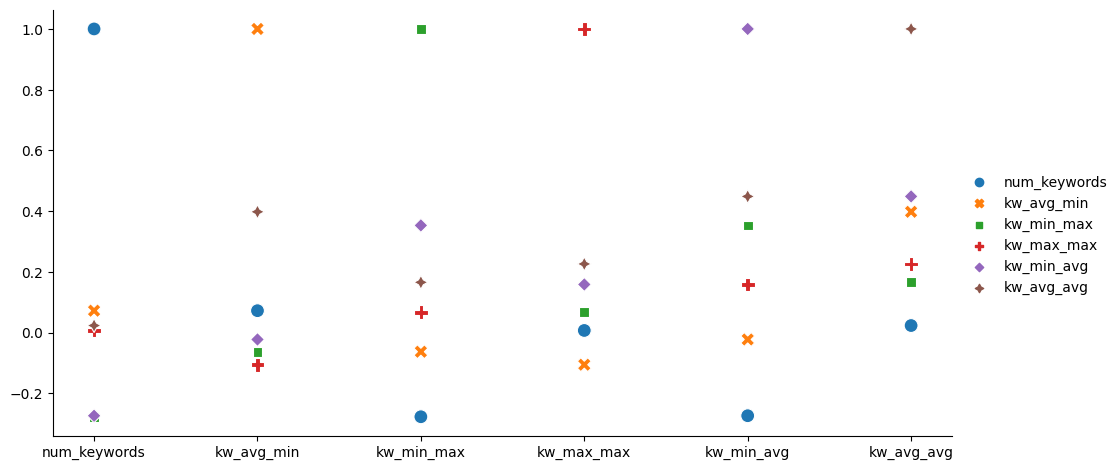

In [7]:
# No more correlations between kw variables.
sns.relplot(kw_filtered.loc[:, ['num_keywords', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_min_avg', 'kw_avg_avg']].corr(), 
            height = 5, aspect = 2, s = 100)

df_filtered = copy.deepcopy(kw_filtered)

# Fill missing values, drop non predictive columns and work on weekdays

In [8]:
# url,id  and time delta are not predictive column --> drop them
df_filtered = df_filtered.drop(['url','timedelta'], axis = 1)

# fill missing values with the mean of their column
columns_to_fill = ['num_imgs', 'num_videos', 'num_keywords']

# Fill missing values with the mean
df_filtered[columns_to_fill] = df_filtered[columns_to_fill].fillna(df_filtered[columns_to_fill].mean())


Difference between the two means: 656



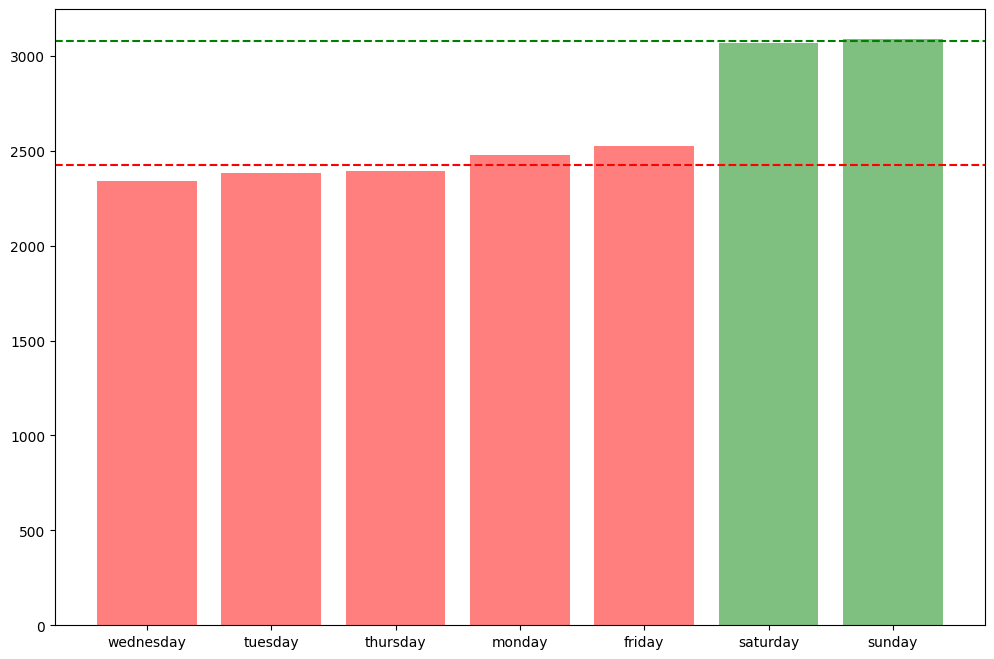

In [9]:

shares_per_day = df_filtered.groupby('weekday')['shares'].sum()
n_weekdays     = df_filtered.groupby('weekday').size()

normalized_shares_per_day = shares_per_day / n_weekdays 
plt.bar(x = normalized_shares_per_day.sort_values().index, height = normalized_shares_per_day.sort_values().values, color = ['red', 'red','red','red','red', 'green', 'green'], alpha = 0.5)
plt.axhline(y = normalized_shares_per_day.sort_values().iloc[0:5].mean(), linestyle = "dashed", color = 'red')
plt.axhline(y = normalized_shares_per_day.sort_values().iloc[5:7].mean(), linestyle = "dashed", color = 'green')

print(f'Difference between the two means: {normalized_shares_per_day.sort_values().iloc[5:7].mean() - normalized_shares_per_day.sort_values().iloc[0:5].mean():.0f}\n')

We can distinguish between weekend and midweek days.

In [10]:
# Replace the values in 'weekday' column with encoded values
df_filtered['weekday'] = np.where(df_filtered['weekday'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']), 'Not Weekend', 'Weekend')

# Tokens

In [11]:
# a lot of values are 0 --> remove them
df_filtered = df_filtered[df_filtered['n_tokens_content'] != 0]


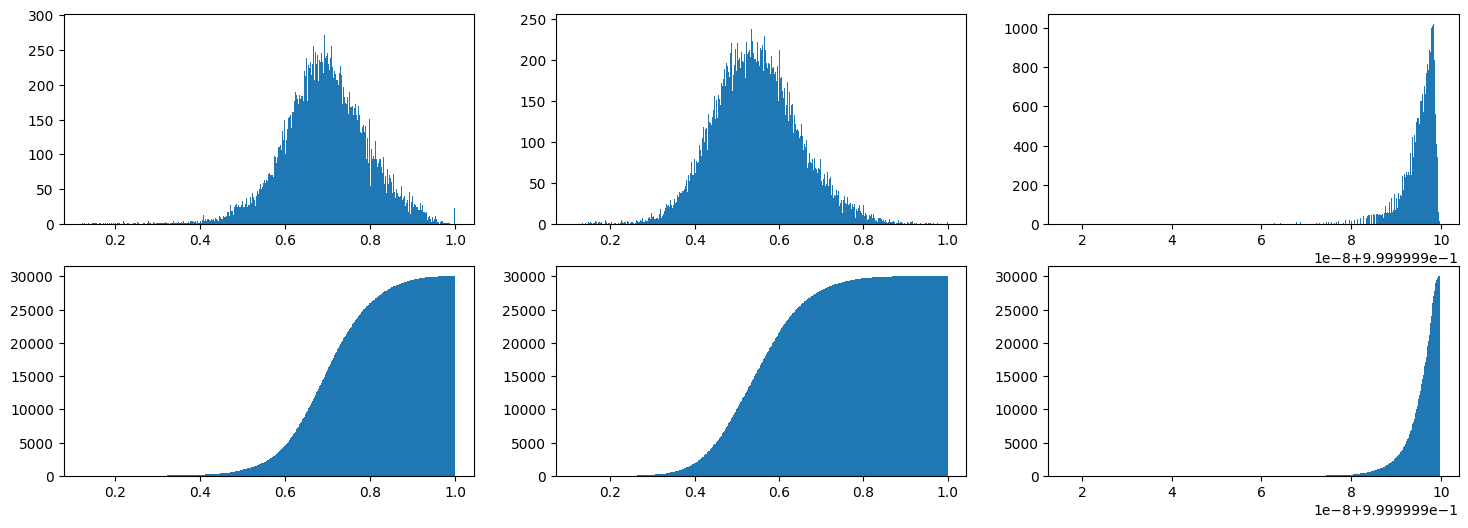

In [12]:
fig, ax = plt.subplots(2, 3, figsize = (18, 6))


_ = ax[0, 0].hist(df_filtered['n_non_stop_unique_tokens'], bins = 500)
_ = ax[0, 1].hist(df_filtered['n_unique_tokens'], bins = 500)
_ = ax[0, 2].hist(df_filtered['n_non_stop_words'], bins = 500)

_ = ax[1, 0].hist(df_filtered['n_non_stop_unique_tokens'], bins = 500, cumulative = True)
_ = ax[1, 1].hist(df_filtered['n_unique_tokens'], bins = 500, cumulative = True)
_ = ax[1, 2].hist(df_filtered['n_non_stop_words'], bins = 500, cumulative = True)



Can we get rid of n_non_stop_words? No variance, no information: discard

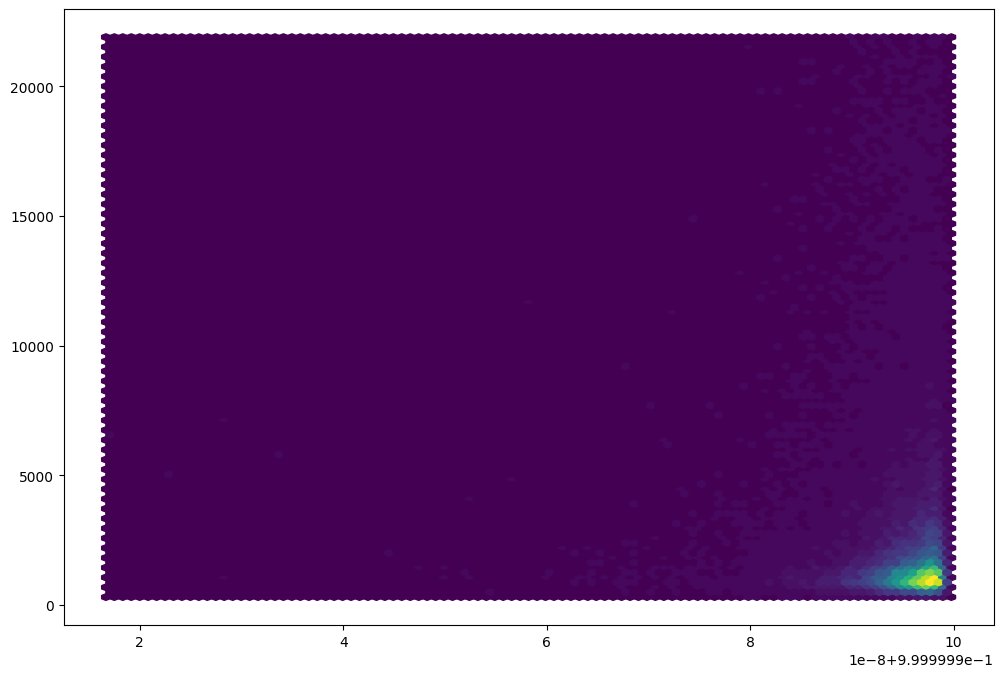

In [13]:
corr = df_filtered.loc[:, ['n_non_stop_words', 'shares']].corr()
_ = plt.hexbin(x = df_filtered['n_non_stop_words'], y = df_filtered['shares'], bins = 50)

In [14]:
df_filtered = df_filtered.drop(['n_non_stop_words'], axis = 1)

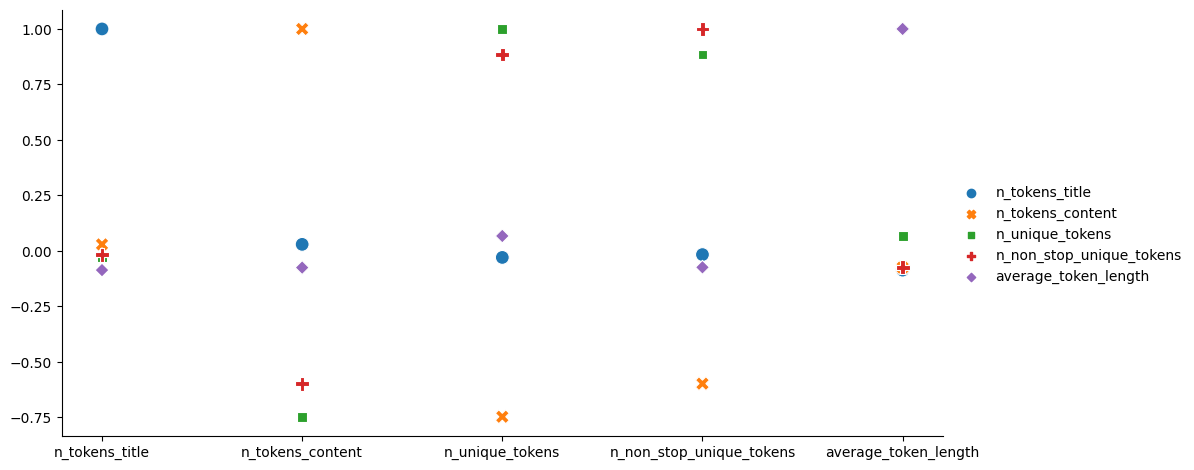

In [15]:
corr_tokens = df_filtered.loc[:, ['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_unique_tokens', 'average_token_length']].corr()
_ = sns.relplot(corr_tokens, height = 5, aspect = 2, s = 100)


* n_unique_tokens strongly positively correlated to n_non_stop_unique_tokens > 0.85
* n_tokens_content strongly negatively correlated to n_unique_tokens < -0.75    correlate negativamente quindi tanto piu è lunga tanto meno i tokens unici

* n_tokens_content quite positively correlated to n_non_stop_unique_tokens > 0.60

We can safely discard some features. We choose to <br>

**KEEP**
* n_unique_tokens

**DISCARD**
* n_non_stop_unique_tokens
* n_tokens_content



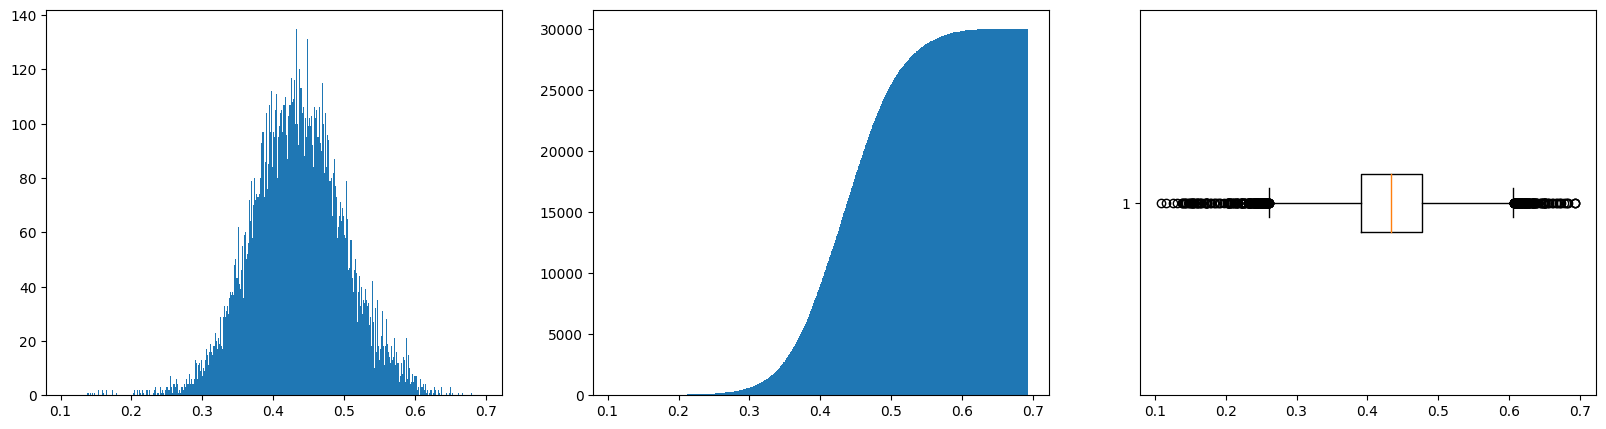

In [16]:
fig, ax = plt.subplots(1, 3, figsize = (20, 5))

_ = ax[0].hist(np.log1p(df_filtered['n_unique_tokens']), bins = 1000)
_ = ax[1].hist(np.log1p(df_filtered['n_unique_tokens']), bins = 1000, cumulative = True)
_ = ax[2].boxplot(np.log1p(df_filtered['n_unique_tokens']), vert = False)


In [17]:
# We can safely discard the correlated features.
df_filtered = df_filtered.drop(['n_tokens_content', 'n_non_stop_unique_tokens'], axis = 1)

# References

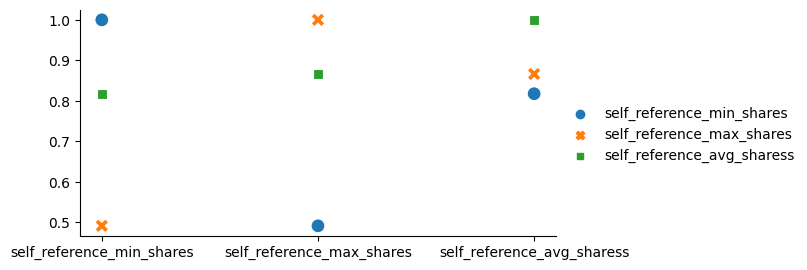

In [18]:
corr_reference = df_filtered.loc[:, ['self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess']].corr()

_ = sns.relplot(corr_reference, height = 3, aspect = 2, s = 100)

* self_reference_avg_sharess strongly positively correlated to self_reference_max_shares > 0.85
* self_reference_avg_sharess strongly positively correlated to self_reference_min_shares > 0.80

We can safely discard some features. We choose to <br>

**KEEP**
* self_reference_avg_sharess

**DISCARD**
* self_reference_max_shares
* self_reference_min_shares


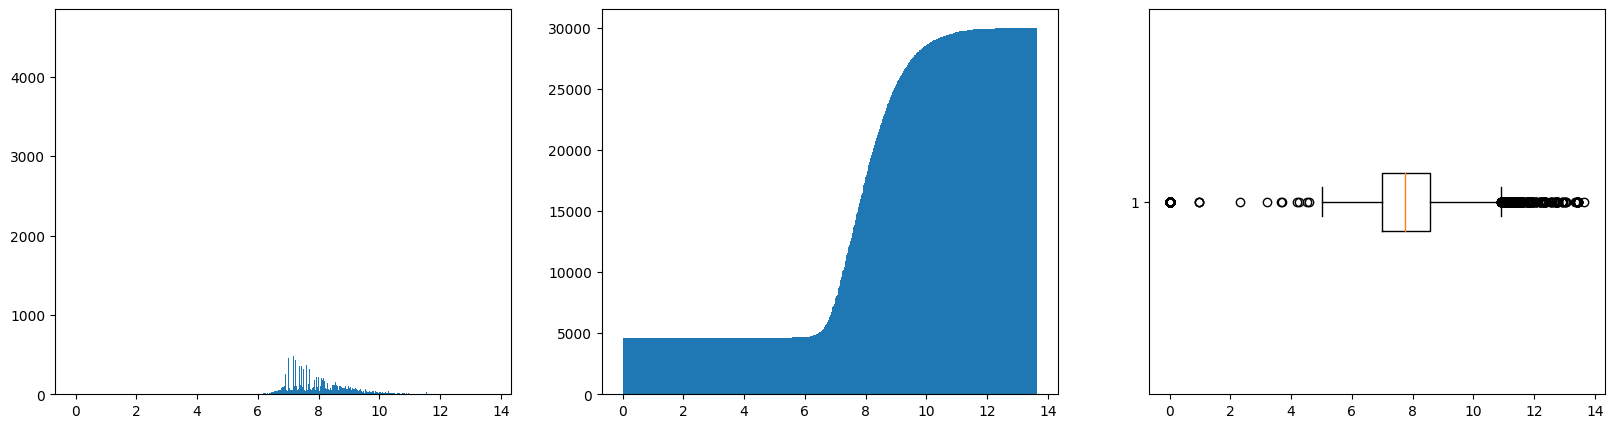

In [19]:
fig, ax = plt.subplots(1, 3, figsize = (20, 5))

_ = ax[0].hist(np.log1p(df_filtered['self_reference_avg_sharess']), bins = 1000)
_ = ax[1].hist(np.log1p(df_filtered['self_reference_avg_sharess']), bins = 1000, cumulative = True)
_ = ax[2].boxplot(np.log1p(df_filtered['self_reference_avg_sharess']), vert = False)

# Outliers?

In [20]:
df_filtered = df_filtered.drop(['self_reference_max_shares', 'self_reference_min_shares'], axis = 1)

# Topic and polarity

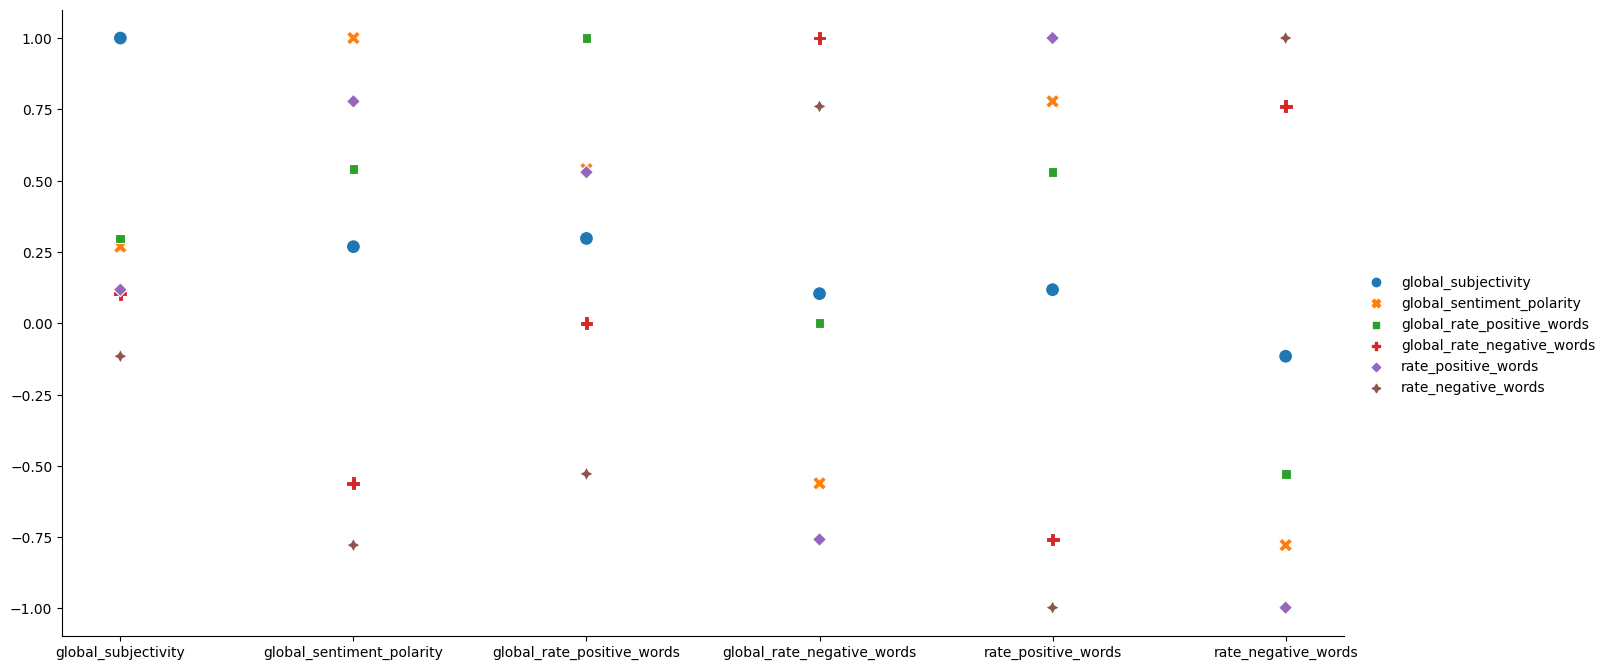

In [21]:
corr_polarity = df_filtered.loc[:, ['global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'rate_positive_words', 'rate_negative_words']].corr()
_ = sns.relplot(corr_polarity, height = 7, aspect = 2, s = 100)

In [22]:
df_filtered = df_filtered.drop(['rate_positive_words', 'rate_negative_words'], axis = 1)

* global_sentiment_polarity strongly positively correlated to rate_positive_words > 0.75
* global_sentiment_polarity strongly negatively correlated to rate_negative_words < -0.75


We can safely discard some features. We choose to <br>

**KEEP**
* global_sentiment_polarity

**DISCARD**
* rate_positive_words
* rate_negative_words


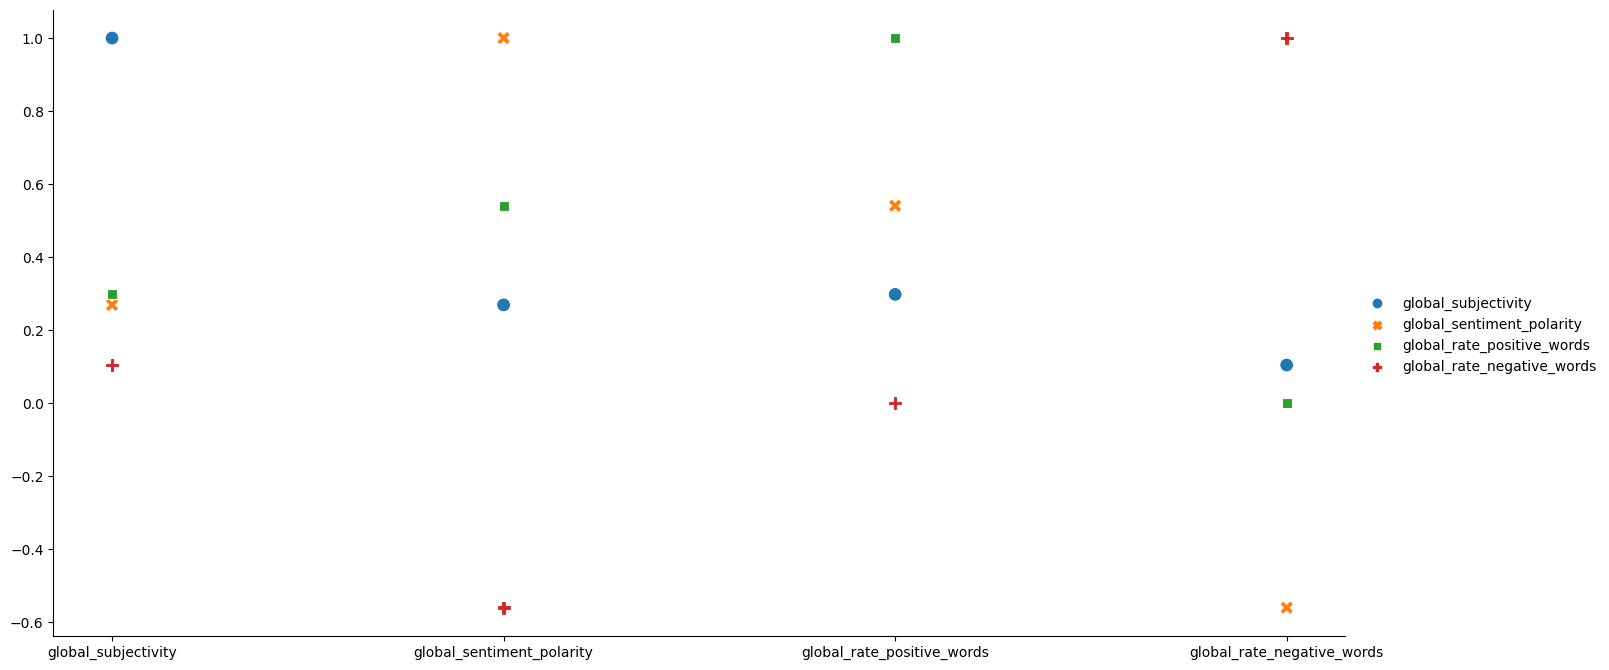

In [23]:
corr_polarity =  df_filtered.loc[:, ['global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words']].corr()
_ = sns.relplot(corr_polarity, height = 7, aspect = 2, s = 100)

# We may try some linear combinations.

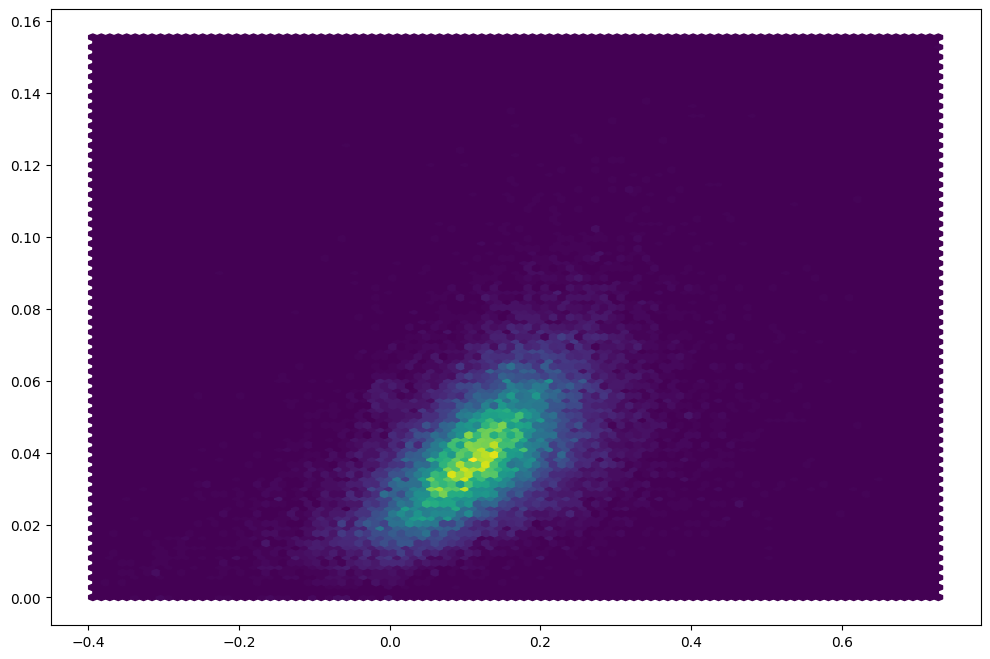

In [24]:
plt.hexbin(x = df_filtered['global_sentiment_polarity'], y = df_filtered['global_rate_positive_words'])

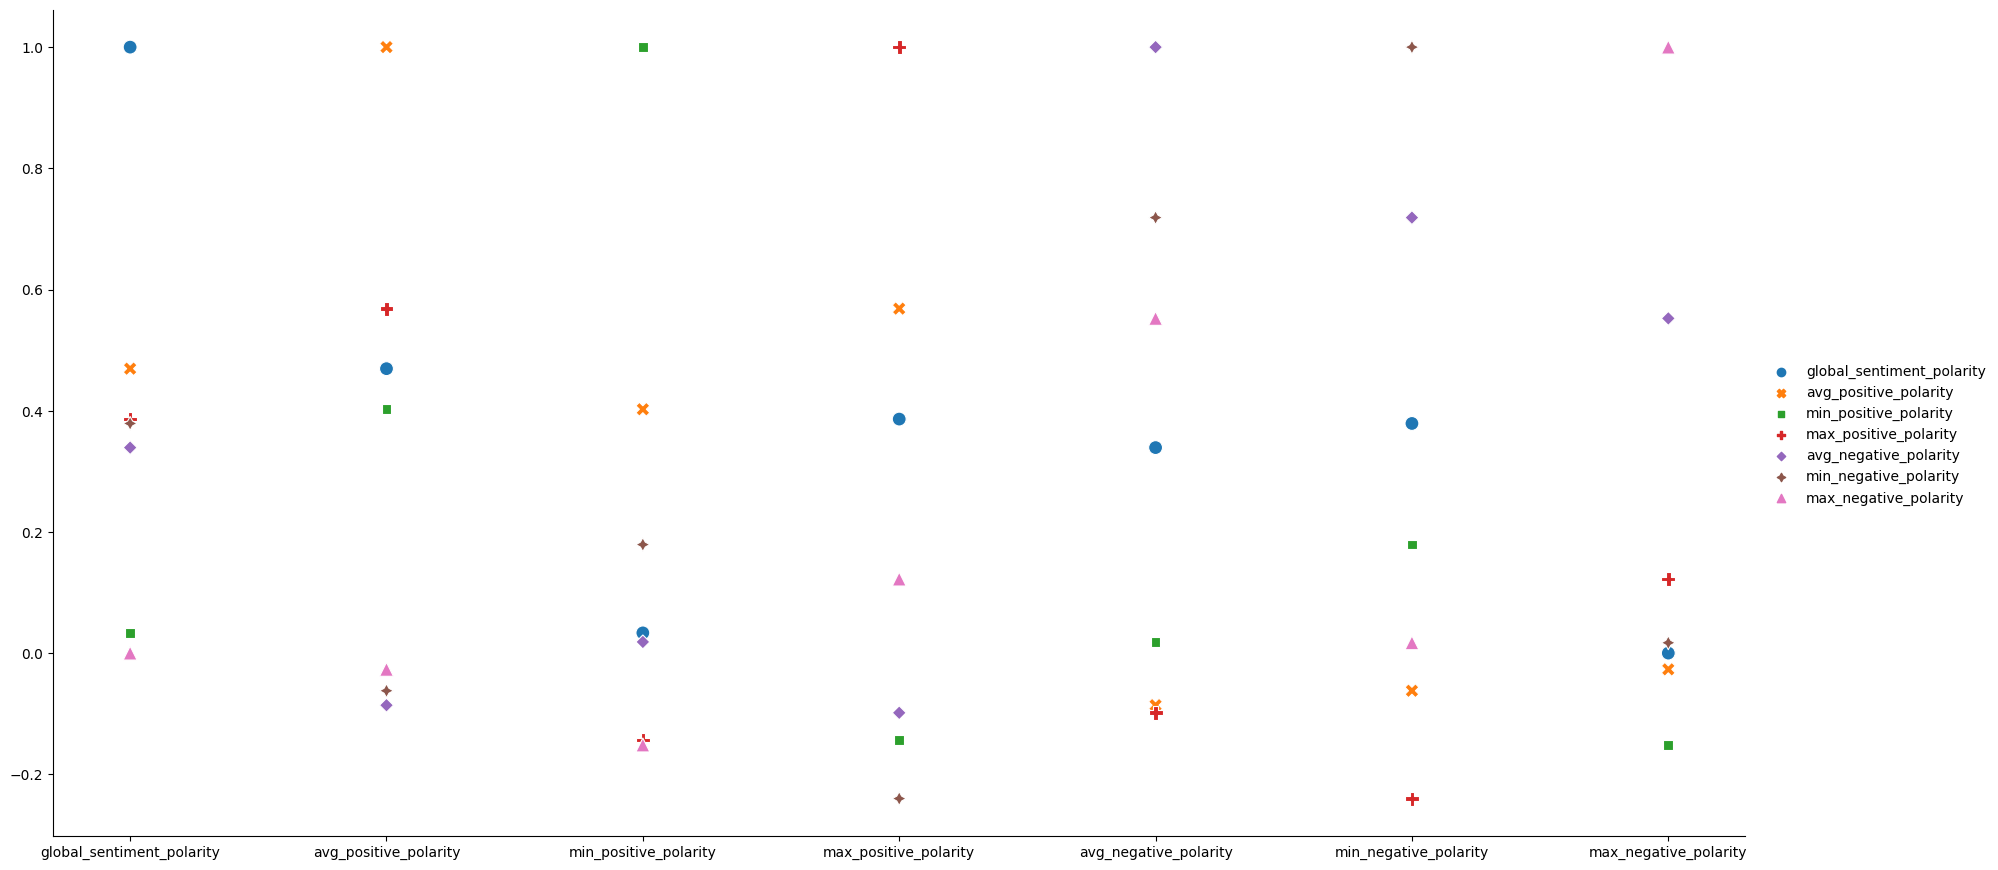

In [25]:
corr_polarity = df_filtered.loc[:, ['global_sentiment_polarity', 'avg_positive_polarity', 'min_positive_polarity',
       'max_positive_polarity', 'avg_negative_polarity',
       'min_negative_polarity', 'max_negative_polarity']].corr()
_ = sns.relplot(corr_polarity, height = 9, aspect = 2, s = 100)


We decide to keep just the averages, but linear combinations to be considered. <br>

**KEEP**
* avg_positive_polarity
* avg_negative_polarity

**DISCARD**
* max_positive_polarity
* max_negative_polarity
* min_positive_polarity
* min_negative_polarity


In [26]:
df_filtered = df_filtered.drop(['max_positive_polarity', 'min_positive_polarity', 'min_negative_polarity', 'max_negative_polarity'], axis = 1)

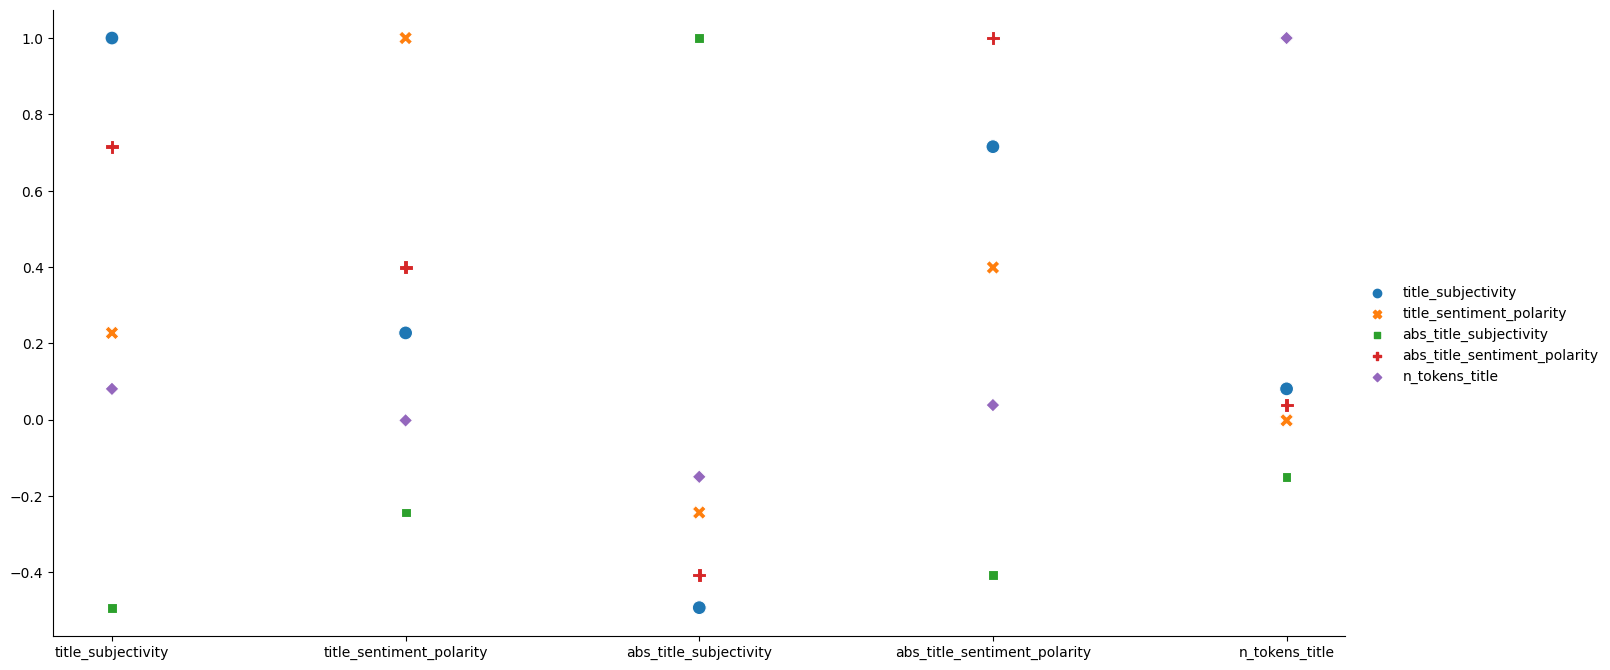

In [27]:
# Make a new feature by combining title_subjectivity and title_sentiment_polarity.
corr_polarity = df_filtered.loc[:, ['title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'abs_title_sentiment_polarity', 'n_tokens_title']].corr()
_ = sns.relplot(corr_polarity, height = 7, aspect = 2, s = 100)

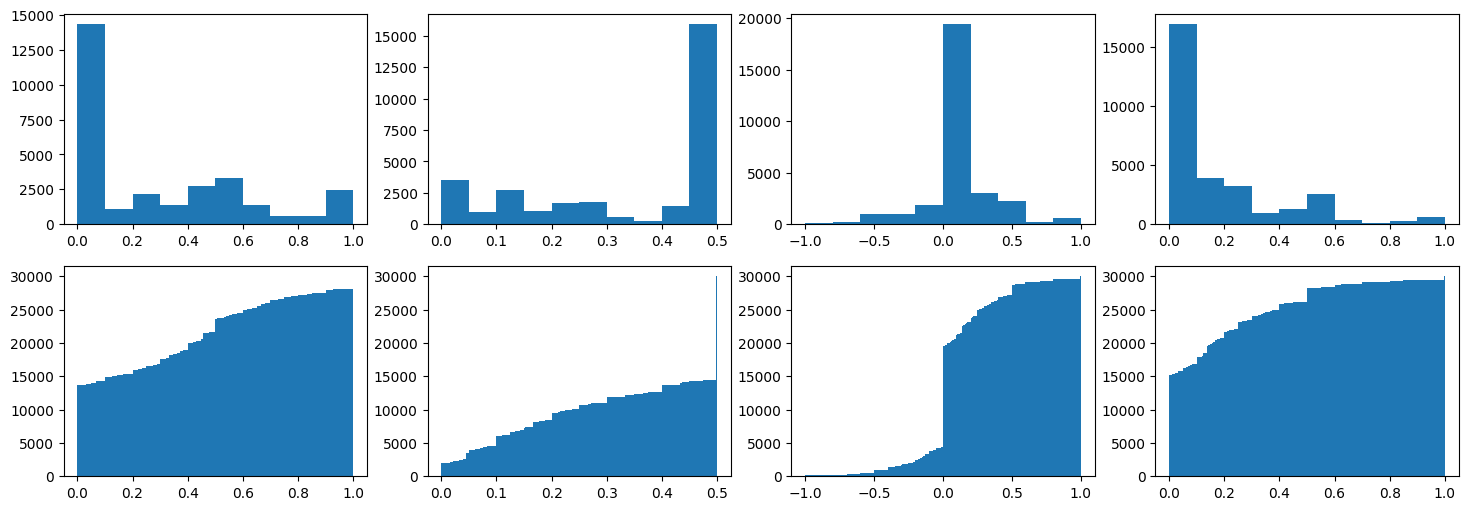

In [28]:
fig, ax = plt.subplots(2, 4, figsize = (18, 6))


_ = ax[0, 0].hist(df_filtered['title_subjectivity'], bins = 10)
_ = ax[0, 1].hist(df_filtered['abs_title_subjectivity'], bins = 10)
_ = ax[0, 2].hist(df_filtered['title_sentiment_polarity'], bins = 10)
_ = ax[0, 3].hist(df_filtered['abs_title_sentiment_polarity'], bins = 10)

_ = ax[1, 0].hist(df_filtered['title_subjectivity'], bins = 500, cumulative = True)
_ = ax[1, 1].hist(df_filtered['abs_title_subjectivity'], bins = 500, cumulative = True)
_ = ax[1, 2].hist(df_filtered['title_sentiment_polarity'], bins = 500, cumulative = True)
_ = ax[1, 3].hist(df_filtered['abs_title_sentiment_polarity'], bins = 500, cumulative = True)

Linear combinations to be considered. <br>

**KEEP**
* title_subjectivity
* title_sentiment_polarity

**DISCARD**
* abs_title_subjectivity
* abs_title_sentiment_polarity


In [29]:
df_filtered = df_filtered.drop(['abs_title_subjectivity', 'abs_title_sentiment_polarity'], axis = 1)

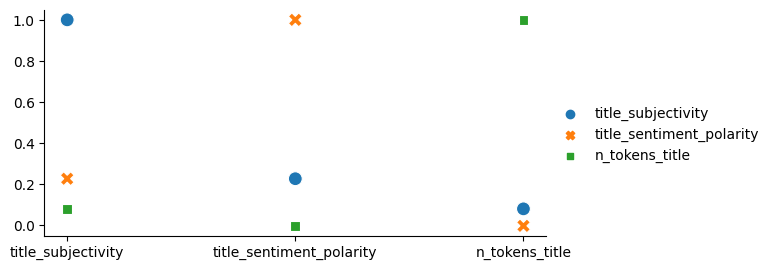

In [30]:
corr_polarity = df_filtered.loc[:, ['title_subjectivity',
       'title_sentiment_polarity', 'n_tokens_title']].corr()
_ = sns.relplot(corr_polarity, height = 3, aspect = 2, s = 100)

In [31]:
corr_tot = df_filtered.loc[:, ['n_tokens_title', 'n_unique_tokens', 'num_hrefs', 'num_self_hrefs',
       'num_imgs', 'num_videos', 'average_token_length', 'num_keywords',
       'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_min_avg', 'kw_avg_avg',
       'self_reference_avg_sharess', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03',
       'LDA_04', 'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'avg_positive_polarity', 'avg_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'shares']].corr()

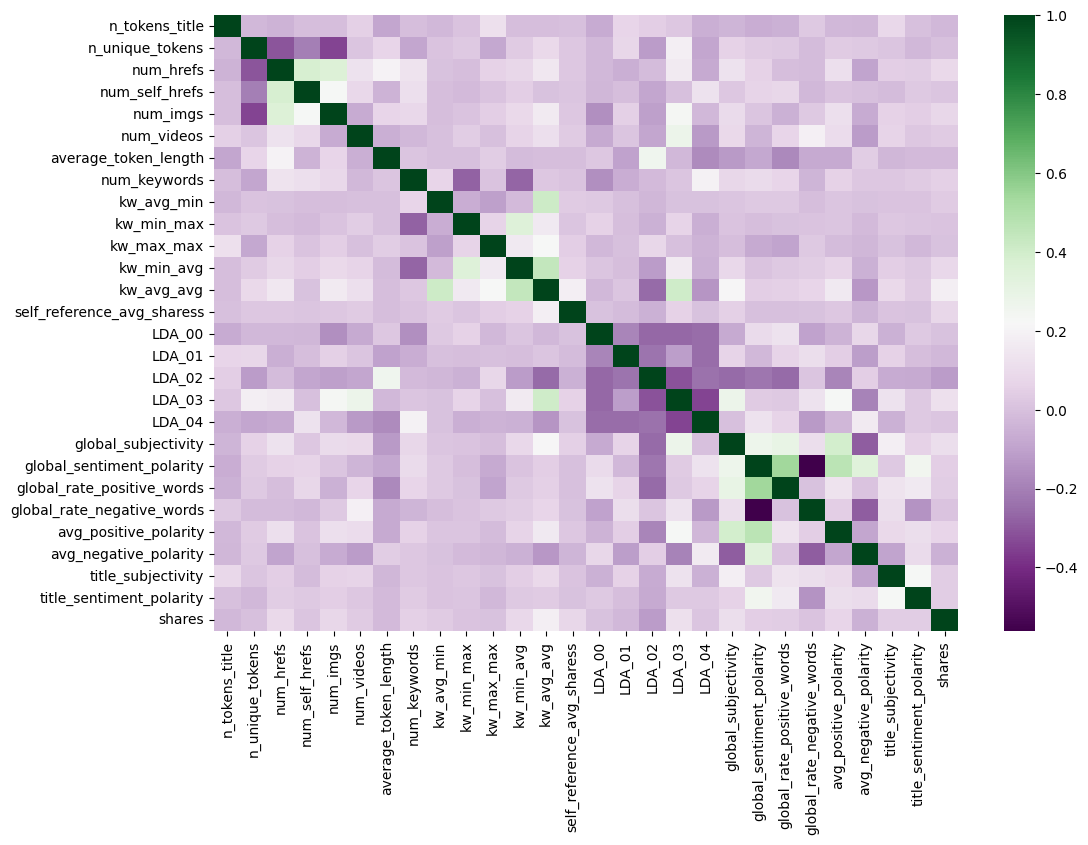

In [32]:
# _ = sns.relplot(corr_tot, height = 12, aspect = 4, s = 100)
_ = sns.heatmap(corr_tot, cmap = 'PRGn')

In [33]:
# Not necessary since trees handle categorical values.
# Data_channel --> it takes only 5 values, so it will be encoded with one hot encoding
# one_hot_encoded = pd.get_dummies(df['data_channel'])

# # Concatenate the one-hot encoded columns with the original DataFrame
# df = pd.concat([df, one_hot_encoded], axis=1)
# df  = df.drop('data_channel', axis=1)

In [34]:

# # self_reference
# df['self_reference'] = df['self_reference_avg_sharess'] * 0.6 + df['self_reference_max_shares'] * 0.2 + df['self_reference_min_shares'] * 0.2

# df = df.drop(['self_reference_avg_sharess','self_reference_max_shares','self_reference_min_shares'],axis=1)

In [35]:
# rate_positive/ rate_negative
# look at the correlation btw these two variables with share
# print('Correlation btw rate_positive_words and rate_negative_words ',df[['rate_positive_words', 'rate_negative_words', 'shares']].corr())

# # rate_positive_words AND rate_negative_words are equally correlated with shares --> delete rate_negative_words
# df = df.drop(['rate_negative_words'],axis=1)

# Change scale

In [36]:
df_filtered.columns

Index(['n_tokens_title', 'n_unique_tokens', 'num_hrefs', 'num_self_hrefs',
       'num_imgs', 'num_videos', 'average_token_length', 'num_keywords',
       'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_min_avg', 'kw_avg_avg',
       'self_reference_avg_sharess', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03',
       'LDA_04', 'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'avg_positive_polarity', 'avg_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'shares', 'data_channel', 'weekday',
       'discretized_kw_avg_max'],
      dtype='object')

Text(0.5, 1.0, 'log num_videos')

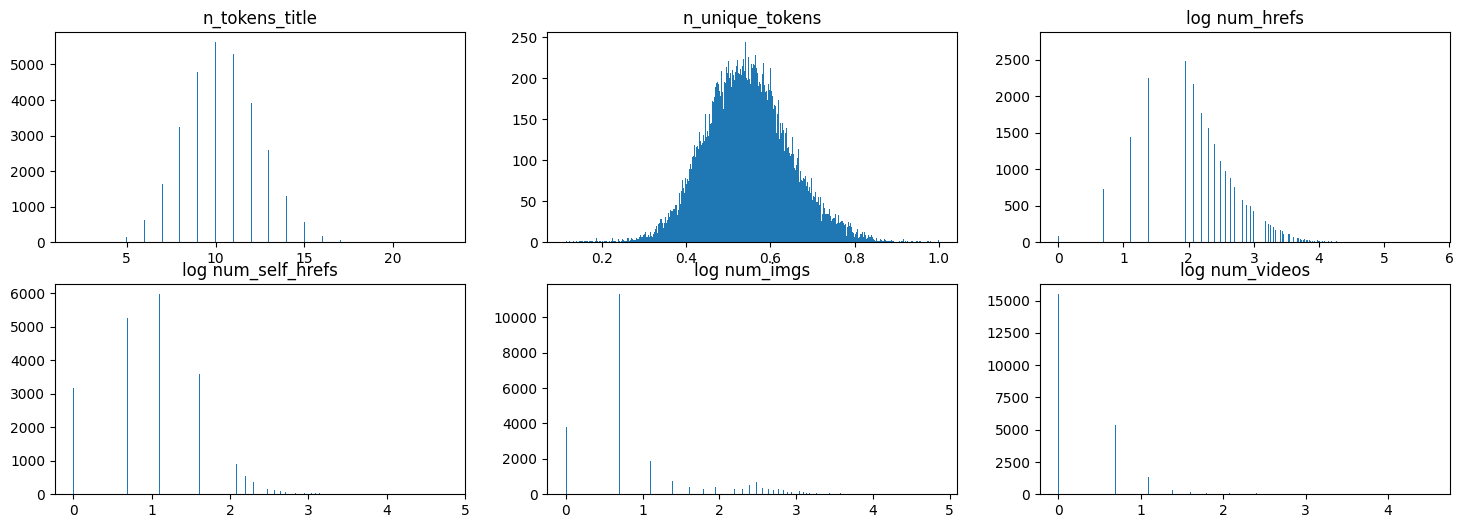

In [37]:
fig, ax = plt.subplots(2, 3, figsize = (18, 6))

# df_filtered_out = df_filtered[np.log1p(df_filtered['num_imgs']) < 3]
# df_filtered_out = df_filtered_out[np.log1p(df_filtered_out['num_videos']) < 2]

_ = ax[0, 0].hist(df_filtered['n_tokens_title'], bins = 500)
ax[0, 0].set_title('n_tokens_title')

_ = ax[0, 1].hist(df_filtered['n_unique_tokens'], bins = 500)
ax[0, 1].set_title('n_unique_tokens')

_ = ax[0, 2].hist(np.log1p(df_filtered['num_hrefs']), bins = 500)
ax[0, 2].set_title('log num_hrefs')

_ = ax[1, 0].hist(np.log1p(df_filtered['num_self_hrefs']), bins = 500)
ax[1, 0].set_title('log num_self_hrefs')

_ = ax[1, 1].hist(np.log1p(df_filtered['num_imgs']), bins = 500)
ax[1, 1].set_title('log num_imgs')

_ = ax[1, 2].hist(np.log1p(df_filtered['num_videos']), bins = 500)
ax[1, 2].set_title('log num_videos')

AttributeError: 'numpy.ndarray' object has no attribute 'hist'

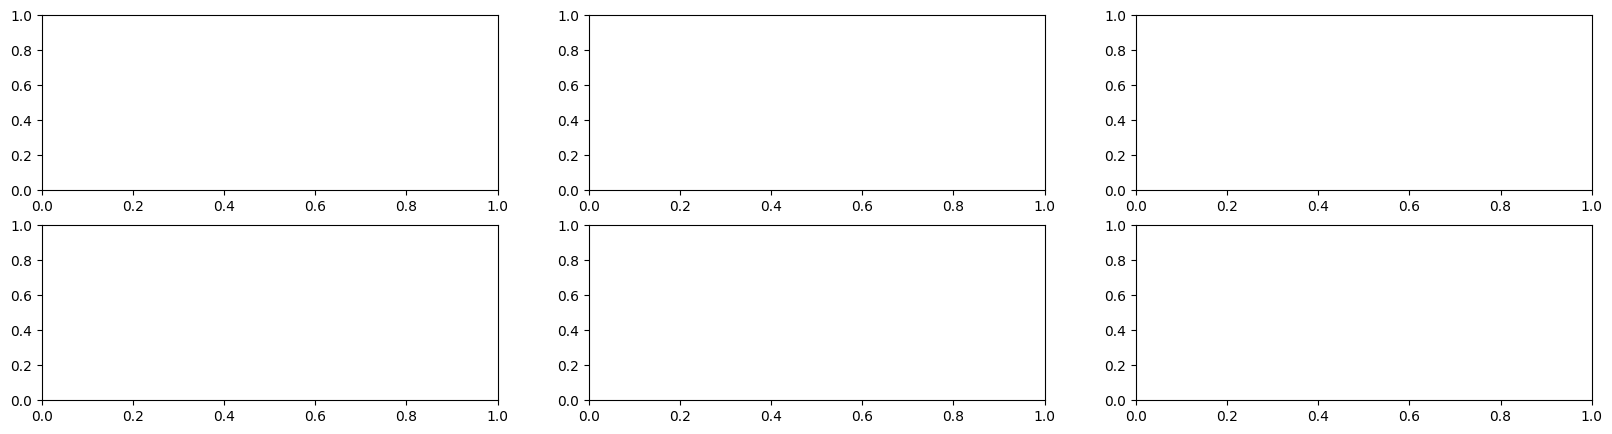

In [38]:
# We discard outliers using two subjective thresholds.
min = 300
max = 4
df_filtered_out = df_filtered[np.log1p(df_filtered['num_hrefs']) < max]

fig, ax = plt.subplots(2, 3, figsize = (20, 5))

ax[0].hist(np.log1p(df_filtered_out['num_hrefs']), bins = 100)
ax[1].hist(np.log1p(df_filtered_out['num_hrefs']), bins = 1000, cumulative = True)
ax[2].boxplot(np.log1p(df_filtered_out['num_hrefs']), vert = False)

print(f"{len(df_filtered_out['shares'])} from {len(df_filtered['shares'])}\n{len(df_filtered_out['shares']) / len(df_filtered['shares'])*100:.2f}% of observations retained.")


29690 from 30022
98.89% of observations retained.


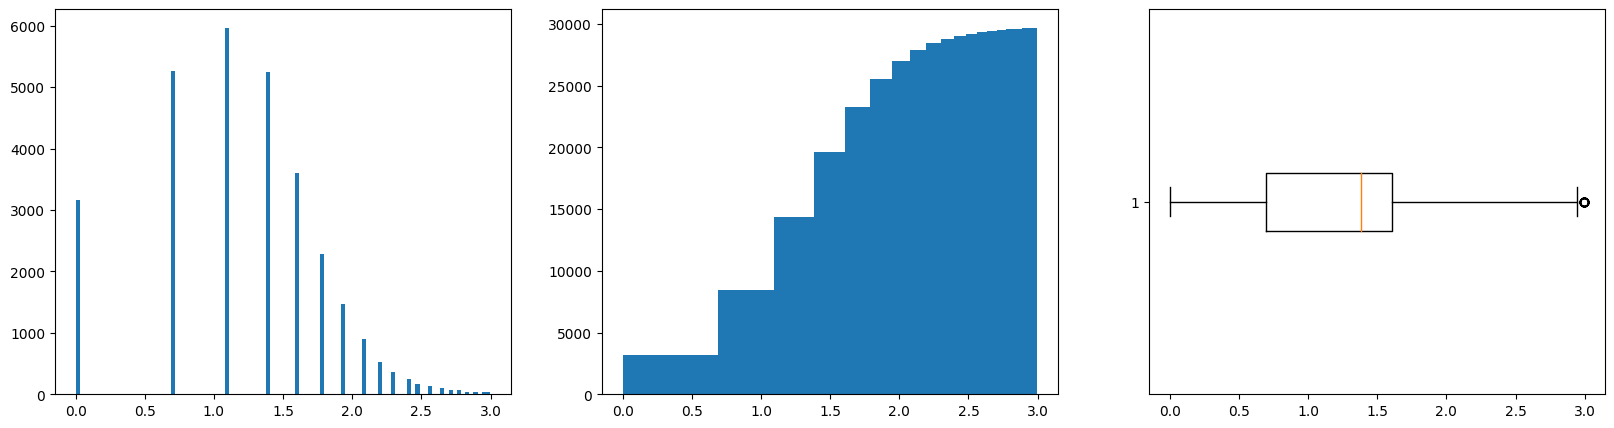

In [39]:
# We discard outliers using two subjective thresholds.
min = 300
max = 3
df_filtered_out = df_filtered[np.log1p(df_filtered['num_self_hrefs']) < max]

fig, ax = plt.subplots(1, 3, figsize = (20, 5))

ax[0].hist(np.log1p(df_filtered_out['num_self_hrefs']), bins = 100)
ax[1].hist(np.log1p(df_filtered_out['num_self_hrefs']), bins = 1000, cumulative = True)
ax[2].boxplot(np.log1p(df_filtered_out['num_self_hrefs']), vert = False)

print(f"{len(df_filtered_out['shares'])} from {len(df_filtered['shares'])}\n{len(df_filtered_out['shares']) / len(df_filtered['shares'])*100:.2f}% of observations retained.")


Discard outliers from hrefs

In [40]:
df_filtered = df_filtered[np.log1p(df_filtered['num_hrefs']) < 4]
df_filtered = df_filtered[np.log1p(df_filtered['num_self_hrefs']) < 3]

In [41]:
df_filtered.columns

Index(['n_tokens_title', 'n_unique_tokens', 'num_hrefs', 'num_self_hrefs',
       'num_imgs', 'num_videos', 'average_token_length', 'num_keywords',
       'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_min_avg', 'kw_avg_avg',
       'self_reference_avg_sharess', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03',
       'LDA_04', 'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'avg_positive_polarity', 'avg_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'shares', 'data_channel', 'weekday',
       'discretized_kw_avg_max'],
      dtype='object')

Text(0.5, 1.0, 'log kw_min_avg')

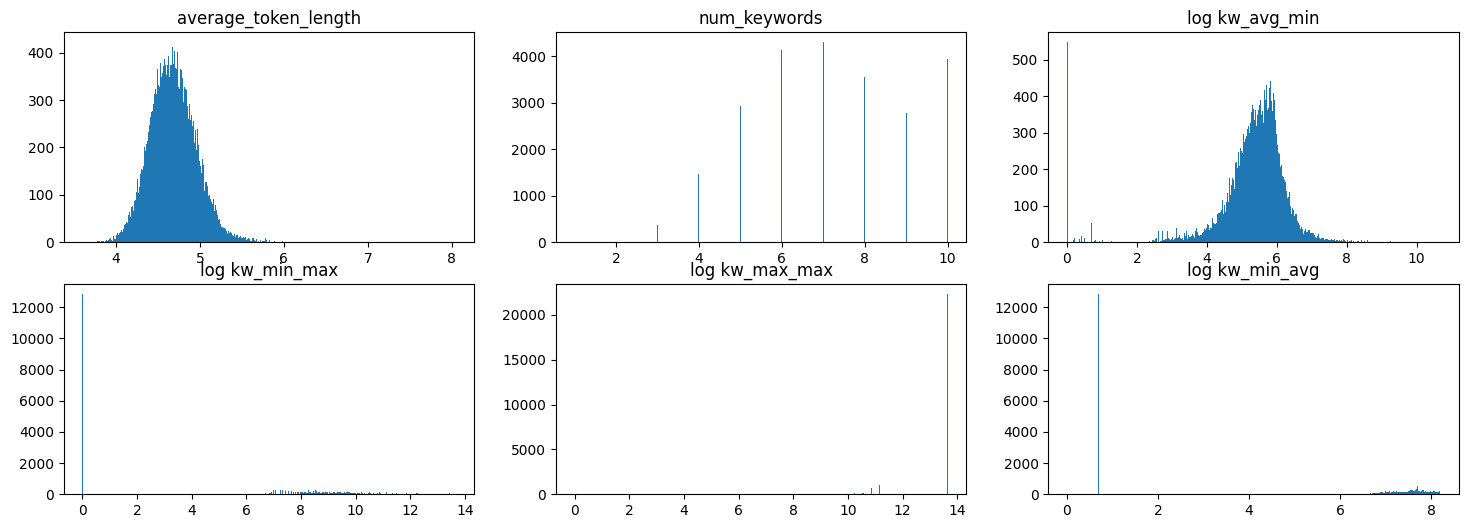

In [42]:
fig, ax = plt.subplots(2, 3, figsize = (18, 6))

# df_filtered_out = df_filtered[np.log1p(df_filtered['num_imgs']) < 3]
# df_filtered_out = df_filtered_out[np.log1p(df_filtered_out['num_videos']) < 2]

_ = ax[0, 0].hist(df_filtered['average_token_length'], bins = 500)
ax[0, 0].set_title('average_token_length')

_ = ax[0, 1].hist(df_filtered['num_keywords'], bins = 500)
ax[0, 1].set_title('num_keywords')

_ = ax[0, 2].hist(np.log1p(df_filtered['kw_avg_min'] + 1), bins = 500)
ax[0, 2].set_title('log kw_avg_min')

_ = ax[1, 0].hist(np.log1p(df_filtered['kw_min_max']), bins = 500)
ax[1, 0].set_title('log kw_min_max')

_ = ax[1, 1].hist(np.log1p(df_filtered['kw_max_max']), bins = 500)
ax[1, 1].set_title('log kw_max_max')

_ = ax[1, 2].hist(np.log1p(df_filtered['kw_min_avg'] + 1), bins = 500)
ax[1, 2].set_title('log kw_min_avg')

In [43]:
df_filtered = df_filtered.drop(['kw_min_max', 'kw_max_max', 'kw_min_avg'], axis = 1)

We decide to drop kw_min_max, kw_max_max and kw_min_avg because not representative. We keep kw_avg_min because along with kw_avg_max may be useful.

In [44]:
df_filtered.columns

Index(['n_tokens_title', 'n_unique_tokens', 'num_hrefs', 'num_self_hrefs',
       'num_imgs', 'num_videos', 'average_token_length', 'num_keywords',
       'kw_avg_min', 'kw_avg_avg', 'self_reference_avg_sharess', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'avg_positive_polarity',
       'avg_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'shares', 'data_channel', 'weekday',
       'discretized_kw_avg_max'],
      dtype='object')

Text(0.5, 1.0, 'log LDA_03')

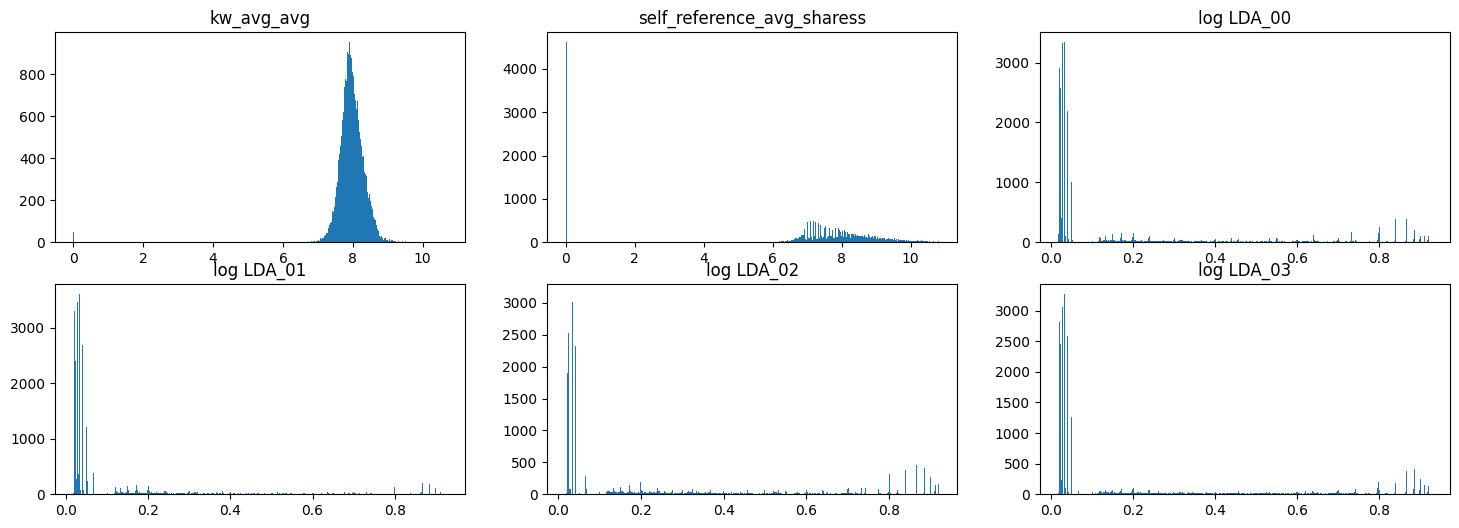

In [45]:
fig, ax = plt.subplots(2, 3, figsize = (18, 6))

# df_filtered_out = df_filtered[np.log1p(df_filtered['num_imgs']) < 3]
# df_filtered_out = df_filtered_out[np.log1p(df_filtered_out['num_videos']) < 2]

_ = ax[0, 0].hist(np.log1p(df_filtered['kw_avg_avg']), bins = 500)
ax[0, 0].set_title('kw_avg_avg')

_ = ax[0, 1].hist(np.log1p(df_filtered[df_filtered['self_reference_avg_sharess'] < 50000]['self_reference_avg_sharess']), bins = 500)
ax[0, 1].set_title('self_reference_avg_sharess')

_ = ax[0, 2].hist(df_filtered['LDA_00'], bins = 500)
ax[0, 2].set_title('log LDA_00')

_ = ax[1, 0].hist(df_filtered['LDA_01'], bins = 500)
ax[1, 0].set_title('log LDA_01')

_ = ax[1, 1].hist(df_filtered['LDA_02'], bins = 500)
ax[1, 1].set_title('log LDA_02')

_ = ax[1, 2].hist(df_filtered['LDA_03'], bins = 500)
ax[1, 2].set_title('log LDA_03')

Remove values that are too high for self_reference_avg_sharess

In [46]:
print(df_filtered.shape)
print(df_filtered[df_filtered['self_reference_avg_sharess'] < 50000].shape)
df_filtered = df_filtered[df_filtered['self_reference_avg_sharess'] < 50000]

(29429, 28)
(28921, 28)


In [47]:
df_filtered.columns

Index(['n_tokens_title', 'n_unique_tokens', 'num_hrefs', 'num_self_hrefs',
       'num_imgs', 'num_videos', 'average_token_length', 'num_keywords',
       'kw_avg_min', 'kw_avg_avg', 'self_reference_avg_sharess', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'avg_positive_polarity',
       'avg_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'shares', 'data_channel', 'weekday',
       'discretized_kw_avg_max'],
      dtype='object')

Text(0.5, 1.0, 'log avg_negative_polarity')

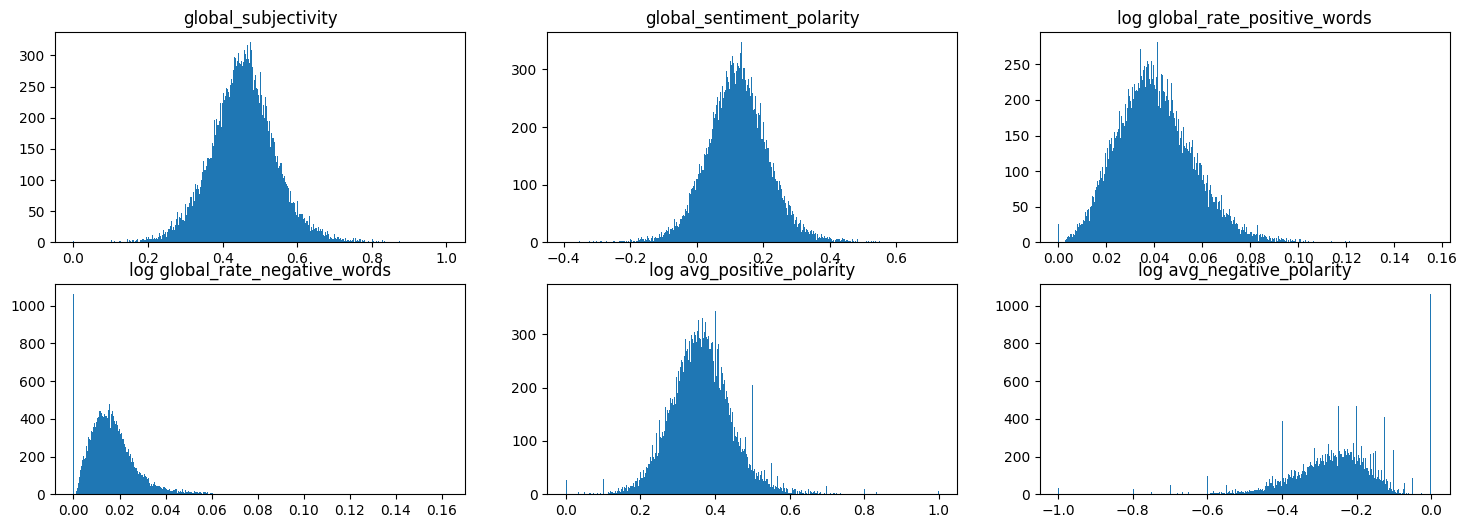

In [48]:
fig, ax = plt.subplots(2, 3, figsize = (18, 6))

# df_filtered_out = df_filtered[np.log1p(df_filtered['num_imgs']) < 3]
# df_filtered_out = df_filtered_out[np.log1p(df_filtered_out['num_videos']) < 2]

_ = ax[0, 0].hist(df_filtered['global_subjectivity'], bins = 500)
ax[0, 0].set_title('global_subjectivity')

_ = ax[0, 1].hist(df_filtered['global_sentiment_polarity'], bins = 500)
ax[0, 1].set_title('global_sentiment_polarity')

_ = ax[0, 2].hist(df_filtered['global_rate_positive_words'], bins = 500)
ax[0, 2].set_title('log global_rate_positive_words')

_ = ax[1, 0].hist(df_filtered['global_rate_negative_words'], bins = 500)
ax[1, 0].set_title('log global_rate_negative_words')

_ = ax[1, 1].hist(df_filtered['avg_positive_polarity'], bins = 500)
ax[1, 1].set_title('log avg_positive_polarity')

_ = ax[1, 2].hist(df_filtered['avg_negative_polarity'], bins = 500)
ax[1, 2].set_title('log avg_negative_polarity')

In [49]:
df_filtered.columns

Index(['n_tokens_title', 'n_unique_tokens', 'num_hrefs', 'num_self_hrefs',
       'num_imgs', 'num_videos', 'average_token_length', 'num_keywords',
       'kw_avg_min', 'kw_avg_avg', 'self_reference_avg_sharess', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'avg_positive_polarity',
       'avg_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'shares', 'data_channel', 'weekday',
       'discretized_kw_avg_max'],
      dtype='object')

Text(0.5, 1.0, 'log shares')

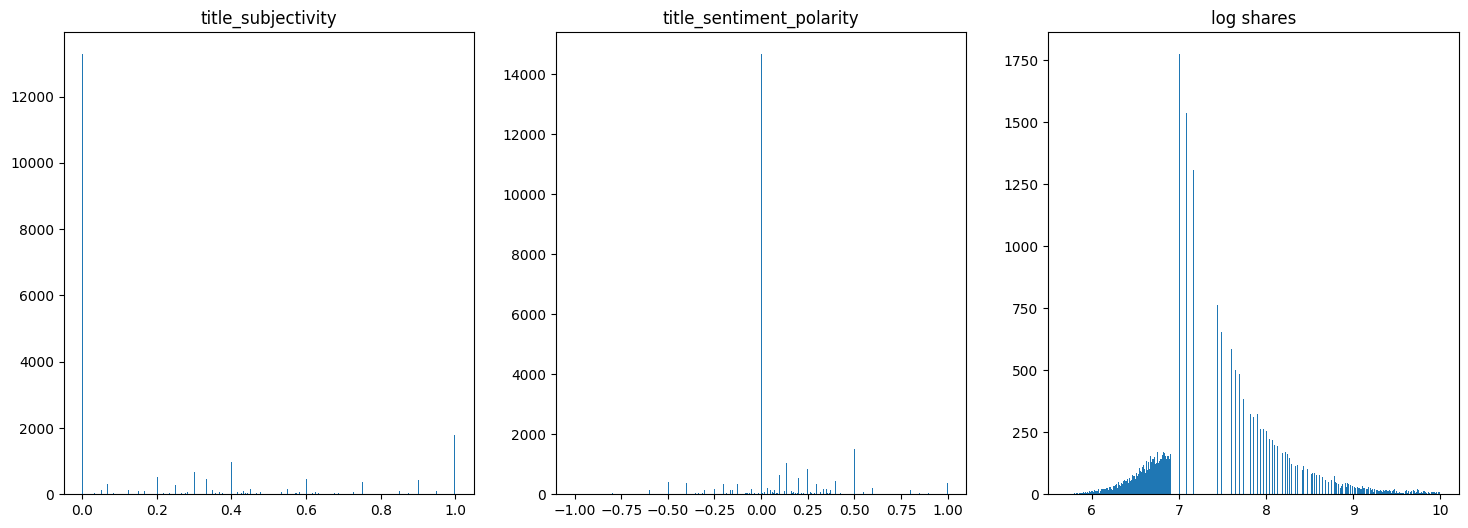

In [50]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

# df_filtered_out = df_filtered[np.log1p(df_filtered['num_imgs']) < 3]
# df_filtered_out = df_filtered_out[np.log1p(df_filtered_out['num_videos']) < 2]

_ = ax[0].hist(df_filtered['title_subjectivity'], bins = 500)
ax[0].set_title('title_subjectivity')

_ = ax[1].hist(df_filtered['title_sentiment_polarity'], bins = 500)
ax[1].set_title('title_sentiment_polarity')

_ = ax[2].hist(np.log1p(df_filtered['shares']), bins = 500)
ax[2].set_title('log shares')


Discretized the variables

# Apply transformations

In [51]:
# Define the mapping for title_sentiment_polarity
polarity_mapping = {
    (-1, -0.50): 'high_negative',
    (-0.49, 0.000000001): 'low_negative',
    0: 'None',
    (0.000000001, 0.49): 'low_positive',
    (0.5, 1): 'high_positive'
}

# Apply the mapping to categorize the columns
df_filtered['title_subjectivity'] = pd.cut(df_filtered['title_subjectivity'], bins = [-0.000001, 0.000001, 0.334, 0.667, 1], labels = ['pippo', 'low', 'medium', 'high'], right = True)
df_filtered['title_sentiment_polarity'] = pd.cut(df_filtered['title_sentiment_polarity'], bins=[-1.00001, -0.5, -0.000000001, +0.000000001, 0.5, 1], labels=['high_negative', 'low_negative', 'pippo', 'low_positive', 'high_positive'], right = True)

In [52]:

df_filtered['title_subjectivity']


0         pippo
1         pippo
2         pippo
3        medium
4           low
          ...  
31709       low
31710     pippo
31712     pippo
31713      high
31714       low
Name: title_subjectivity, Length: 28921, dtype: category
Categories (4, object): ['pippo' < 'low' < 'medium' < 'high']

In [53]:
df_filtered['num_hrefs'] = np.log1p(df_filtered['num_hrefs'])
df_filtered['num_self_hrefs'] = np.log1p(df_filtered['num_self_hrefs'])
df_filtered['num_imgs'] = np.log1p(df_filtered['num_imgs'])
df_filtered['num_videos'] = np.log1p(df_filtered['num_videos'])
df_filtered['kw_avg_min'] = np.log1p(df_filtered['kw_avg_min'] + 1)
df_filtered['kw_avg_avg'] = np.log1p(df_filtered['kw_avg_avg'])
df_filtered['self_reference_avg_sharess'] = np.log1p(df_filtered['self_reference_avg_sharess'])
df_filtered['shares'] = np.log1p(df_filtered['shares'])
# df_filtered['discretized_kw_avg_max']
# df_filtered['weekday']
one_hot_encoded = pd.get_dummies(df_filtered['data_channel'])

# Concatenate the one-hot encoded columns with the original DataFrame
df_filtered = pd.concat([df_filtered, one_hot_encoded], axis = 1)
df_filtered  = df_filtered.drop('data_channel', axis = 1)

one_hot_encoded = pd.get_dummies(df_filtered['weekday'])

# Concatenate the one-hot encoded columns with the original DataFrame
df_filtered = pd.concat([df_filtered, one_hot_encoded], axis = 1)
df_filtered  = df_filtered.drop('weekday', axis = 1)

one_hot_encoded = pd.get_dummies(df_filtered['discretized_kw_avg_max'])

# Concatenate the one-hot encoded columns with the original DataFrame
df_filtered = pd.concat([df_filtered, one_hot_encoded], axis = 1)
df_filtered  = df_filtered.drop('discretized_kw_avg_max', axis = 1)

one_hot_encoded = pd.get_dummies(df_filtered['title_subjectivity'])

# Concatenate the one-hot encoded columns with the original DataFrame
df_filtered = pd.concat([df_filtered, one_hot_encoded], axis = 1)
df_filtered  = df_filtered.drop('title_subjectivity', axis = 1)

one_hot_encoded = pd.get_dummies(df_filtered['title_sentiment_polarity'])

# Concatenate the one-hot encoded columns with the original DataFrame
df_filtered = pd.concat([df_filtered, one_hot_encoded], axis = 1)
df_filtered  = df_filtered.drop('title_sentiment_polarity', axis = 1)

In [75]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error


X = np.array(df_filtered.drop(['shares'], axis=1))
y = df_filtered['shares']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)



In [76]:
def gradient_boosting_regressor(n_components = 5):
    #without PCA
    grad_bost_regr = GradientBoostingRegressor()
    grad_bost_regr.fit(X_train,y_train)
    y_pred = grad_bost_regr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'GradientBoostingRegressor without PCA')
    print(f'rmse : {rmse}')
    print()
    print()
    print()
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    # Transform the test data using the trained PCA model
    X_test_pca = pca.transform(X_test)
    regr_pca = GradientBoostingRegressor()
    regr_pca.fit(X_train_pca, y_train)
    y_pred_pca = regr_pca.predict(X_test_pca)
    mse_pca = mean_squared_error(y_test, y_pred_pca)
    rmse_pca = np.sqrt(mse_pca)
    print(f'GradientBoostingRegressor with PCA')
    print(f'rmse_pca : {rmse_pca}')

In [77]:
gradient_boosting_regressor()

GradientBoostingRegressor without PCA
rmse : 0.7405508472248588



GradientBoostingRegressor with PCA
rmse_pca : 0.7736330541410253
